In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import crflux.models as pm
from MCEq.core import MCEqRun

MC_neutrinos_dir = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Monte_Carlo_all_events_all_variables.csv"

db_MC_neutrinos = pd.read_csv(MC_neutrinos_dir)


In [ ]:
db_MC_neutrinos_cut = db_MC_neutrinos[(db_MC_neutrinos['energy'] > 1)                   #at least 50 GeV (start of data from paper)
                                      & (db_MC_neutrinos['energy'] < 10000)             #at most 10 TeV
                                      & (db_MC_neutrinos['interaction_type'] != -1)     #remove undefined interaction type
                                      & (db_MC_neutrinos['interaction_type'] != 0)]      #remove non-interacting neutrinos
                                      #& (abs(db_MC_neutrinos['pid']) != 16)]            #remove tau neutrinos

db_MC_neutrinos_cut.save_to_csv("MC_neutrinos_cut_1GeV_10TeV_no_noninteracting.csv", index=False)

In [ ]:
''' Copied from https://mceq.readthedocs.io/en/latest/examples/Simple_zenith_averaged_neutrinos.html'''

mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model 
# 
# (so only cosmic rays? problem?) ^^
#
# support a tuple (primary model class (not instance!), arguments)

primary_model = (pm.HillasGaisser2012, "H3a"),

theta_deg=0.0, #we average so it doesnt matter
)

#Power of energy to scale the flux
mag = 3 #doesnt matter for ratio

#obtain energy grid (fixed) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

#Dictionary for results
flux = {}

#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(1,0,11))*180./np.pi

#Initialize empty grid
for frac in ['numu_total',
             'nue_total','nutau_total']:
    flux[frac] = np.zeros_like(e_grid)


#Sum fluxes, calculated for different angles
for theta in angles:
    mceq_run.set_theta_deg(theta)
    mceq_run.solve()

    flux['numu_total'] += (mceq_run.get_solution('total_numu', mag)
                          + mceq_run.get_solution('total_antinumu', mag))

    flux['nue_total'] += (mceq_run.get_solution('total_nue', mag)
                         + mceq_run.get_solution('total_antinue', mag))


    # since there are no conventional tau neutrinos, prompt=total
    flux['nutau_total'] += (mceq_run.get_solution('total_nutau', mag)
                        + mceq_run.get_solution('total_antinutau', mag))

log_bincenters = mceq_run.e_grid[(mceq_run.e_grid > 1) & (mceq_run.e_grid < 1e4)]

# log_bins are bin centers, so calculate bin edges for log spacing
log_binedges = np.sqrt(log_bincenters[:-1] * log_bincenters[1:])
log_binedges = np.concatenate(([log_bincenters[0] * (log_bincenters[1]/log_bincenters[0])**-0.5], log_binedges, [log_bincenters[-1] * (log_bincenters[-1]/log_bincenters[-2])**0.5]))  # extrapolate edges

#average the results
for frac in ['numu_total',
             'nue_total','nutau_total']:
    flux[frac] = flux[frac]/float(len(angles))
    flux[frac] = np.array([val for i, val in enumerate(flux[frac]) if e_grid[i] in log_bincenters and val != 0])


MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [ ]:
print(db_MC_neutrinos_cut.columns)

Index(['track_mu_pred', 'event_no', 'track_mu', 'energy_pred', 'energy',
       'zenith_pred', 'zenith_kappa', 'zenith', 'azimuth_pred',
       'azimuth_kappa', 'azimuth', 'pid_noise_pred', 'pid_muon_pred',
       'pid_neutrino_pred', 'pid', 'pid_neutrino_pred_logit',
       'position_x_pred', 'position_y_pred', 'position_z_pred', 'position_x',
       'position_y', 'position_z', 'N_pulses', 'N_string', 'N_doms',
       'First_dom_time', 'C2HR6', 'CausalVetoHits', 'CleanedFullTimeLength',
       'DCFiducialHits', 'L3_oscNext_bool', 'NAbove200Hits', 'NchCleaned',
       'NoiseEngineNoCharge', 'RTVetoCutHit', 'STW9000_DTW300Hits',
       'UncleanedFullTimeLength', 'VertexGuessZ', 'VetoFiducialRatioHits',
       'interaction_type', 'total_osc_weight'],
      dtype='object')


In [ ]:
track_cut = 0.5

true_muon_to_total_list = []

NC_list = []
CC_list = []

track_list = []
casc_list = []

for i in range(len(log_bincenters)):
    db_in_bin = db_MC_neutrinos_cut[(db_MC_neutrinos_cut['energy'] > log_binedges[i]) & (db_MC_neutrinos_cut['energy'] <= log_binedges[i+1])]

    true_taus = len(db_in_bin[abs(db_in_bin['pid']) == 16])
    true_muons = len(db_in_bin[abs(db_in_bin['pid']) == 14])
    true_elecs = len(db_in_bin[abs(db_in_bin['pid']) == 12])
    true_muon_to_total_list.append(true_muons / (true_taus+true_muons+true_elecs))
    
    NC = len(db_in_bin[db_in_bin['interaction_type'] == 1])
    CC = len(db_in_bin[db_in_bin['interaction_type'] == 2])
    NC_list.append(NC)
    CC_list.append(CC)

    tracks = len(db_in_bin[db_in_bin['track_mu_pred'] > track_cut])
    track_list.append(tracks)
    cascs = len(db_in_bin[db_in_bin['track_mu_pred'] <= track_cut])
    casc_list.append(cascs)


ZeroDivisionError: division by zero

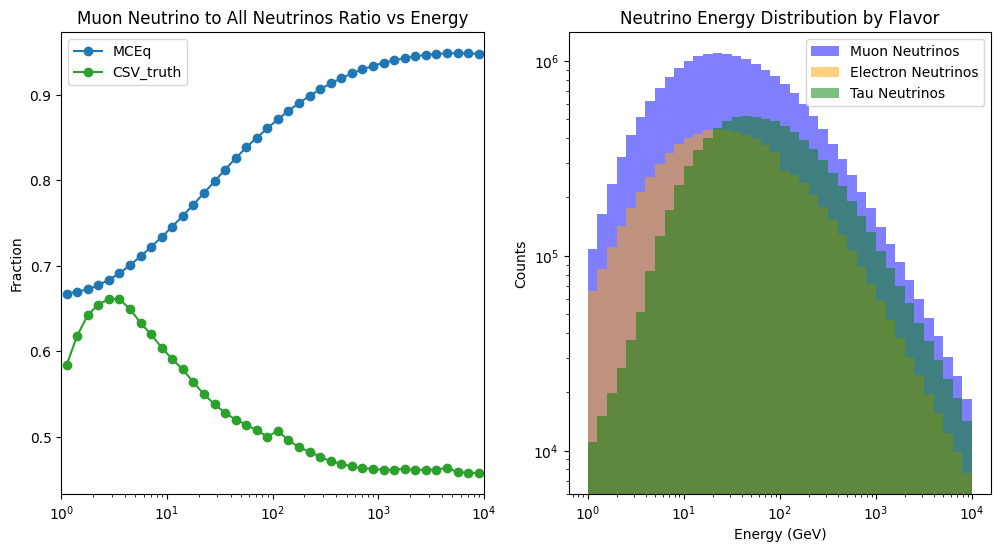

In [ ]:
mu_to_all = flux['numu_total']/(flux['nue_total']+flux['numu_total']+flux['nutau_total'])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(log_bincenters, mu_to_all, marker='o', label='MCEq', color='tab:blue')

ax[0].set_ylabel('Fraction')
ax[0].set_title('Muon Neutrino to All Neutrinos Ratio vs Energy')

ax[0].plot(log_bincenters, true_muon_to_total_list, marker='o', label='CSV_truth', color='tab:green')
ax[0].set_xlim([1, 10000])
ax[0].set_xscale('log')
ax[0].legend()

bins = np.logspace(np.log10(db_MC_neutrinos_cut['energy'].min()), np.log10(db_MC_neutrinos_cut['energy'].max()), 41)
ax[1].set_xscale('log')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 14]['energy'], bins=bins, alpha=0.5, label='Muon Neutrinos', color='blue')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 12]['energy'], bins=bins, alpha=0.5, label='Electron Neutrinos', color='orange')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 16]['energy'], bins=bins, alpha=0.5, label='Tau Neutrinos', color='green')
ax[1].set_xlabel('Energy (GeV)')
ax[1].set_yscale('log')
ax[1].set_ylabel('Counts')
ax[1].set_title('Neutrino Energy Distribution by Flavor')
ax[1].legend()


In [ ]:

# Define quark list and their (I3, Q) values
_quarks = {
    'u': {'I3':  0.5, 'Q':  2/3},
    'c': {'I3':  0.5, 'Q':  2/3},
    'd': {'I3': -0.5, 'Q': -1/3},
    's': {'I3': -0.5, 'Q': -1/3},
    'b': {'I3': -0.5, 'Q': -1/3},
    # top quark not included (threshold very high, negligible PDF in nucleon at relevant x)
}

def gL_gR_for_quark(q, sin2w):
    """Return (gL, gR) for quark q given sin^2(theta_W)."""
    I3 = _quarks[q]['I3']
    Q  = _quarks[q]['Q']
    gL = I3 - Q * sin2w
    gR = - Q * sin2w
    return gL, gR

def coupling_squared_sum(sin2w):
    """
    Compute S(sin2w) = sum_q w_q * (gL^2 + gR^2)
    If weights is None, use equal weights for each quark in _quarks.
    weights should be a dict mapping quark->weight (nonnegative).
    """
    S = 0.0
    for q in _quarks.keys():
        gL, gR = gL_gR_for_quark(q, sin2w)
        S += (gL**2 + gR**2)
    return S

def R_of_sin2w(sin2w, sin2w_ref=0.23126):
    """
    Return scaling factor R(sin2w) = S(sin2w) / S(sin2w_ref)
    where S = sum_q w_q (gL^2 + gR^2).
    """
    S_ref = coupling_squared_sum(sin2w_ref)
    S = coupling_squared_sum(sin2w)
    return S / S_ref

def scale_sigma_NC(sigma_NC_ref, sin2w, sin2w_ref=0.2229):
    """
    Scale a reference sigma_NC (scalar or numpy array) by R(sin2w).
    Returns scaled sigma_NC for same shape as sigma_NC_ref.
    """
    R = R_of_sin2w(sin2w, sin2w_ref=sin2w_ref)
    return np.array(sigma_NC_ref) * float(R), float(R)

#0.2229 from standard model 1- (Mw)/(Mz)^2 


# ----------------------- Demo / sanity checks -----------------------
# Toy reference sigma_NC(E) (units arbitrary) as a function of energy.
energies = np.array([50, 100, 200, 500, 1000, 2000, 5000])  # GeV

sigma_NC_ref = np.array([0.10, 0.20, 0.41, 1.0, 2.0, 3.8, 8.6]) * 1e-36  #from paper

# Compute scaling factors for a few sin2w choices
sin2w_values = [0.220, 0.2229, 0.23126, 0.240]
results = []
for s in sin2w_values:
    scaled_sigma, R = scale_sigma_NC(sigma_NC_ref, s)
    results.append({'sin2w': s, 'R': R})

# Print results
print("Coupling-squared scaling factors R(sin2w) (equal-quark weights):")
for r in results:
    print(f"  sin^2(theta_W) = {r['sin2w']:.6f}  ->  R = {r['R']:.6f}")

# Show an example scaled sigma at E = 1e6 GeV (index 4)
idx_example = 4
print("\nExample at E = {:.2g} GeV:".format(energies[idx_example]))
print("  sigma_NC_ref = {:.3e} cm^2".format(sigma_NC_ref[idx_example]))
for r in results:
    scaled_sigma, R = scale_sigma_NC(sigma_NC_ref[idx_example], r['sin2w'])
    print(f"  sin2w={r['sin2w']:.6f} -> scaled sigma_NC = {scaled_sigma:.3e} cm^2 (R={R:.6f})")


Coupling-squared scaling factors R(sin2w) (equal-quark weights):
  sin^2(theta_W) = 0.220000  ->  R = 1.004260
  sin^2(theta_W) = 0.222900  ->  R = 1.000000
  sin^2(theta_W) = 0.231260  ->  R = 0.987989
  sin^2(theta_W) = 0.240000  ->  R = 0.975861

Example at E = 1e+03 GeV:
  sigma_NC_ref = 2.000e-36 cm^2
  sin2w=0.220000 -> scaled sigma_NC = 2.009e-36 cm^2 (R=1.004260)
  sin2w=0.222900 -> scaled sigma_NC = 2.000e-36 cm^2 (R=1.000000)
  sin2w=0.231260 -> scaled sigma_NC = 1.976e-36 cm^2 (R=0.987989)
  sin2w=0.240000 -> scaled sigma_NC = 1.952e-36 cm^2 (R=0.975861)


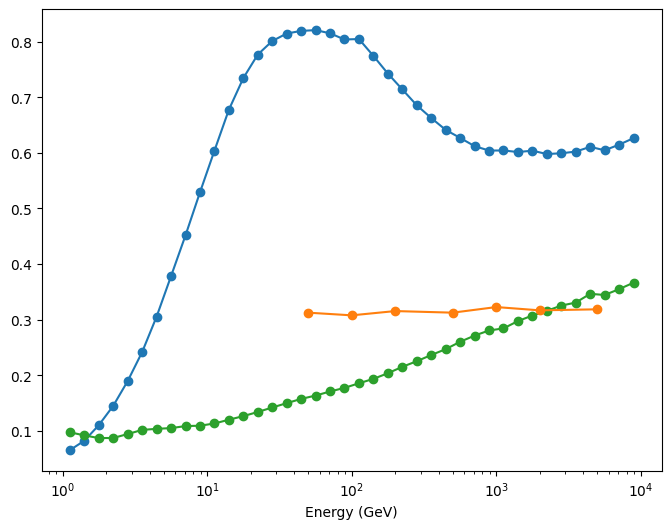

In [ ]:
ratio = np.array(NC_list)/(np.array(CC_list))

pred_ratio =   np.array(track_list)/(np.array(casc_list))

sigma_cc = np.array([0.32, 0.65, 1.3, 3.2, 6.2, 12, 27]) * 1e-36
sigma_nc = np.array([0.10, 0.20, 0.41, 1.0, 2.0, 3.8, 8.6]) * 1e-36
energies_list = np.array([50, 100, 200, 500, 1000, 2000, 5000])  # GeV

true_ratio = sigma_nc / sigma_cc

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(log_bincenters, pred_ratio, marker='o', label='Predicted Track to All Ratio', color='tab:blue')
ax.plot(log_bincenters, ratio, marker='o', label='NC/CC', color='tab:green')
ax.plot(energies_list, true_ratio, marker='o', label='Theoretical CC/NC Ratio', color='tab:orange')
ax.set_xlabel('Energy (GeV)')
ax.set_xscale('log')
ax.legend()
